<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Final-Project-Check-in" data-toc-modified-id="Final-Project-Check-in-1">Final Project Check-in</a></span></li><li><span><a href="#Group-Name" data-toc-modified-id="Group-Name-2">Group Name</a></span></li><li><span><a href="#Student-Names" data-toc-modified-id="Student-Names-3">Student Names</a></span></li><li><span><a href="#Load-Data" data-toc-modified-id="Load-Data-4">Load Data</a></span></li><li><span><a href="#Fit-scikit-learn-model" data-toc-modified-id="Fit-scikit-learn-model-5">Fit scikit-learn model</a></span></li><li><span><a href="#Evaluation-Metric" data-toc-modified-id="Evaluation-Metric-6">Evaluation Metric</a></span></li></ul></div>

Final Project Check-in
------

Group Name
-----

The Grace Hoppers 

Student Names
----

1. Akansha Shrivastava
2. Ivette Sulca
3. Bing Wang

Load Data
-----

In [30]:
from collections import Counter
import imblearn
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import imblearn
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, f1_score, recall_score 
from sklearn.metrics import precision_score, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import geonamescache  #sudo pip install geonamescache
from sklearn.model_selection import RandomizedSearchCV

In [31]:
data_pd = pd.read_csv('../../data/epi_r.csv')
data_json = pd.read_json('../../data/full_format_recipes.json',)
#data_pd = pd.read_csv('data/epi_r.csv')
#data_json = pd.read_json('data/full_format_recipes.json',)

In [32]:
# Deleting null predictive variables from the dataset
data_pd = data_pd.loc[(data_pd.rating>0) & (~data_pd.rating.isna())]

# Deleting drinks
data_pd = data_pd.loc[(data_pd.drink==0) & (data_pd.drinks==0) & (data_pd.cocktail==0)]

# Deleting repeated titles
data_pd.drop_duplicates(subset=['title'], inplace=True)  

In [33]:
# Remove target, "rating", from data_pd
y = data_pd.iloc[:,1]
data_pd = pd.concat([data_pd.iloc[:,0], data_pd.iloc[:,2:]], axis=1)

In [34]:
# Create feature: holidays: Dummy for world holiday 
# (a celebratory day attached to date in calendar-- birthday, graduation, anniversary, etc. not included)
holidays = ["bastille day", "christmas", "christmas eve", "cinco de mayo", "columbus", 
 "diwali", "easter", "father's day", "fourth of july", "friendsgiving", "halloween",
 "hanukkah", "kwanzaa", "labor day", "lunar new year", "mother's day", "new year's day",
 "new year's eve", "oktoberfest", "passover", "persian new year", "purim", "ramadan", 
 "rosh hashanah/yom kippur", "st. patrick's day", "sukkot", "thanksgiving", 
 "valentine's day"]

data_pd["holiday"] = np.where(data_pd[holidays].sum(axis=1)>0, 1, 0)

In [35]:
#FAT: In grams but it can mislead depending of the number of portions (Paella for example)

#Delete bigger portions(Paella) and outliers
y = y.loc[((data_pd.fat>=0) & (data_pd.fat<=200)) | (data_pd.fat.isna())]
data_pd = data_pd.loc[((data_pd.fat>=0) & (data_pd.fat<=200)) | (data_pd.fat.isna())]

#Median imputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
fat_clean = imp.fit_transform(data_pd.fat.values.reshape(-1,1))
fat_clean = pd.DataFrame(data=fat_clean, columns=['fat_clean'])
data_pd['fat'] = fat_clean.fat_clean.values

In [36]:
#PROTEIN CLEANING

#Again, considering values lower than 200: deleting 62 rows...
y = y.loc[((data_pd.protein>=0) & (data_pd.protein<=200)) | (data_pd.protein.isna())]
data_pd = data_pd.loc[((data_pd.protein>=0) & (data_pd.protein<=200)) | (data_pd.protein.isna())]

#Median imputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')
protein_clean = imp.fit_transform(data_pd.protein.values.reshape(-1,1))
protein_clean = pd.DataFrame(data=protein_clean ,columns=['protein_clean'])
data_pd['protein']=protein_clean.protein_clean.values


In [37]:
# SODIUM

#Unit: miligrams
#Very different values, so we will impute only:

imp = SimpleImputer(missing_values=np.nan, strategy='median')
sodium_clean = imp.fit_transform(data_pd.sodium.values.reshape(-1,1))
sodium_clean = pd.DataFrame(data=sodium_clean ,columns=['sodium_clean'])
data_pd['sodium']=sodium_clean.sodium_clean.values

In [38]:
# filtering columns related to "healthy"

# selecting all the relevant columns

selected = ["fat free", "healthy", "low cal", "quick and healthy", 
"low carb",
"low cholesterol",
"low fat",
"low sodium",
"low sugar",
"low/no sugar"]

In [39]:
# filtering rows which have "selected" columns as 1 -> healthy
data_pd["allhealthy"] = 0
for col in selected:
    data_pd.loc[data_pd[col] == 1, "allhealthy"] = 1

In [40]:
# replacing missing values in calories by mean

median = data_pd["calories"].median()
data_pd.loc[data_pd["calories"].isna(), "calories"] = median

In [41]:
# Adding complexity preparation from JSON file

data_json.drop_duplicates(subset=['title'],inplace=True)  
data_json['directions_n_characters']=data_json['directions'].astype(str).str.len()
data_json['ingredients_quantity']=data_json['ingredients'].str.len()
data_json['directions_n_steps']=data_json['directions'].astype(str).str.replace('[','').str.replace(']','').str.split("',").apply(lambda x: len(x))
data_json.loc[data_json.desc.isna(), "desc_n_characters"] = 0
data_json.loc[data_json.desc.notna(), "desc_n_characters"] = data_json["desc"].astype(str).str.len()

data_json2=data_json[['title','directions_n_characters','ingredients_quantity',
                      'directions_n_steps', 'desc_n_characters']]

data_pd=pd.merge(data_pd, data_json2, on='title', how="left")

#Change by imputer
#Median imputer
imp = SimpleImputer(missing_values=np.nan, strategy='median')

directions_n_characters = imp.fit_transform(data_pd.directions_n_characters.values.reshape(-1,1))
directions_n_characters = pd.DataFrame(data=directions_n_characters ,columns=['directions_n_characters'])
data_pd['directions_n_characters']=directions_n_characters.directions_n_characters.values


ingredients_quantity = imp.fit_transform(data_pd.ingredients_quantity.values.reshape(-1,1))
ingredients_quantity = pd.DataFrame(data=ingredients_quantity ,columns=['ingredients_quantity'])
data_pd['ingredients_quantity']=ingredients_quantity.ingredients_quantity.values


directions_n_steps = imp.fit_transform(data_pd.directions_n_steps.values.reshape(-1,1))
directions_n_steps = pd.DataFrame(data=directions_n_steps ,columns=['directions_n_steps'])
data_pd['directions_n_steps']=directions_n_steps.directions_n_steps.values


desc_n_characters = imp.fit_transform(data_pd.desc_n_characters.values.reshape(-1,1))
desc_n_characters = pd.DataFrame(data=desc_n_characters ,columns=['desc_n_characters'])
data_pd['desc_n_characters']=desc_n_characters.desc_n_characters.values


In [42]:
# Identifying locations:
column_names=np.array(data_pd.columns)
column_names=[c.strip().upper() for c in column_names]

gc = geonamescache.GeonamesCache()
countries = gc.get_countries_by_names()
cities = gc.get_cities()
states = gc.get_us_states()

dict_countries=dict()
for k,v in countries.items():
    dict_countries[k.upper()]=[v['geonameid'],v['iso'],v['iso3']]

dict_countries2=dict()
for k,v in countries.items():
    dict_countries2[v['iso'].upper()]=k.upper()

dict_cities=dict()
for k,v in cities.items():
    dict_cities[v['name'].upper()]=[v['geonameid'],v['countrycode']]

dict_states=dict()    
for k,v in states.items():
    dict_states[v['name'].upper()] = [v['geonameid'],v['code'], 'US' ]


In [43]:
# Make dummy variable of if there is a location listed or not

#1. Identifying countries, states and cities

locs=[]
for col in data_pd.columns:    
    if col.upper() in dict_countries:
        if col.upper() not in ['TURKEY']:
#            data_pd.loc[data_pd[col]==1,'country_id'] = dict_countries[col.upper()][1]
#            data_pd.loc[data_pd[col]==1,'country_name'] = col.upper()   
            locs.append(col)
 

    if col.upper() in dict_states:        
#        data_pd.loc[data_pd[col]==1,'state_id'] = dict_states[col.upper()][1]
#        data_pd.loc[data_pd[col]==1,'state_name'] = col.upper()   
#        data_pd.loc[data_pd[col]==1,'country_id'] = 'US'
#        data_pd.loc[data_pd[col]==1,'country_name'] = 'UNITED STATES' 
        locs.append(col)
 
    if col.upper() in dict_cities:     
        if col.upper() not in ['SPRING','ORANGE','WALNUT','LEEK','WEDDING','PLUM','TEQUILA','DATE','PAPAYA','MARSALA','SAKE','RYE','GOUDA','HOLIDAY']:
 #           data_pd.loc[data_pd[col]==1,'city_id'] = dict_cities[col.upper()][0]
 #           data_pd.loc[data_pd[col]==1,'city_name'] = col.upper()   
 #           data_pd.loc[data_pd[col]==1,'country_id'] = dict_cities[col.upper()][1]
 #           data_pd.loc[data_pd[col]==1,'country_name'] = dict_countries2[dict_cities[col.upper()][1]] 
            locs.append(col)

In [44]:
data_pd["locations"] = np.where(data_pd[locs].sum(axis=1)>0, 1, 0)
data_pd.drop(locs, axis=1, inplace=True)

In [18]:
# new_data=data_pd.drop("title", axis=1)
# new_data=new_data.sum()
# new_data=new_data.reset_index()
# new_data.columns=['feature','n_rows']
# new_data.loc[new_data.n_rows<=3]

Fit scikit-learn model
----

In [45]:
# Using the below features in the model:
# X = data_pd[["calories", "protein", "fat", "sodium", "22-minute meals",
#              "3-ingredient recipes", "holiday", "allhealthy", 
#              "directions_n_characters", "directions_n_steps",
#              "ingredients_quantity", "desc_n_characters", "locations"]]
X = data_pd.drop("title", axis=1)

In [46]:
print(y.head())

0    2.500
1    4.375
2    3.750
3    5.000
4    3.125
Name: rating, dtype: float64


In [53]:
y.reset_index()[['rating']]

,rating
0,0.000
1,4.375
2,3.750
3,5.000
4,3.125
...,...
15432,3.750
15433,4.375
15434,4.375
15435,4.375


In [62]:
y_discrete = y.reset_index()[['rating']].copy()
y_discrete.head()

,rating
0,0.000
1,4.375
2,3.750
3,5.000
4,3.125


In [63]:
y_discrete["new_rating"] = 0
y_discrete.loc[y_discrete.rating > 3.5, "new_rating"] = 1
y_discrete.head()


,rating,new_rating
0,0.000,0
1,4.375,1
2,3.750,1
3,5.000,1
4,3.125,0


In [65]:
# y (rating) only appears as 6 different floats between 1 and 4: [1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0]

# Convert floats to categorical variables corresponding to their ratings, 1 to 5, for classification
# (Bins: 1 = [1, 2), 2 = [2, 3), etc.)

"""y_discrete = pd.cut(y, bins=[1, 2, 3], labels=[1, 2], right=False)
y_discrete.value_counts()
y_discrete.shape
print(y_discrete.head())"""
y_discrete["new_rating"].value_counts()


1    13489
0     1948
Name: new_rating, dtype: int64

In [70]:
y_discrete = y_discrete.drop("rating", axis = 1)

In [73]:
y_discrete.columns = ["rating"]

In [74]:
y_discrete.head()

,rating
0,0
1,1
2,1
3,1
4,0


In [19]:
# # Convert y to discrete, without consolidating bins
# # (Only 7 unique values of y: Directly convert to discrete variables using these values as labels)
# y_discrete = pd.cut(y, bins=[1, 1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0], 
#                     labels=[1.25, 1.875, 2.5, 3.125, 3.75, 4.375, 5.0], right=True)
# y_discrete = y_discrete.astype("int")

## Oversampling

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y_discrete, test_size=0.20, stratify=y_discrete)

In [78]:
# Oversampling on lower rating reviews to rebalance classes
sm = imblearn.over_sampling.SMOTE()

In [79]:
X_train_sm, y_train_sm = sm.fit_sample(X_train, y_train)

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [80]:
X_train = pd.DataFrame(X_train_sm, columns=X_train.columns)
y_train = pd.Series(y_train_sm)

In [81]:
# Classes in y_train have been balanced
y_train.value_counts()


1    10791
0    10791
dtype: int64

## Creation of pipelines

In [94]:
rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=10,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [82]:

#Creating pipelines
pipe_lr = Pipeline([('scl', StandardScaler()),
                ('clf', LogisticRegression(penalty='l1', solver='liblinear',random_state=42))])

pipe_kn = Pipeline([('scl', StandardScaler()),
                ('clf', KNeighborsClassifier())])

pipe_nb = Pipeline([
                ('clf', GaussianNB())])

pipe_svc = Pipeline([('scl', StandardScaler()),
                ('clf', SVC(random_state=42))])

pipe_rc = Pipeline([
                ('clf', RandomForestClassifier(random_state=42))])

pipelines=[pipe_lr,pipe_kn,pipe_nb,pipe_svc,pipe_rc]



In [83]:
# Training the pipelines
import time
start_time = time.time()

for pipe in pipelines:
    pipe.fit(X_train, y_train)

print("--- %s seconds ---" % (time.time() - start_time))    

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


--- 286.28453397750854 seconds ---


In [85]:
# Scores on training set
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, roc_auc_score, roc_curve

list_scores = []
for pipe in pipelines:
    y_pred = pipe.predict(X_test)
    
    model_name=pipe.get_params()['clf'].__class__.__name__

    accuracy_s = accuracy_score(y_test, y_pred)
    f1_score_w= f1_score(y_test, y_pred, average='weighted')
    f1_score_m= f1_score(y_test, y_pred, average='macro')    

    list_scores.append([model_name,accuracy_s,f1_score_w,f1_score_m])
    
    print(model_name)
    print(classification_report(y_test, y_pred))

print(list_scores)

LogisticRegression
              precision    recall  f1-score   support

           0       0.17      0.52      0.26       390
           1       0.90      0.64      0.75      2698

    accuracy                           0.62      3088
   macro avg       0.54      0.58      0.50      3088
weighted avg       0.81      0.62      0.69      3088

KNeighborsClassifier
              precision    recall  f1-score   support

           0       0.16      0.48      0.23       390
           1       0.89      0.62      0.73      2698

    accuracy                           0.60      3088
   macro avg       0.52      0.55      0.48      3088
weighted avg       0.80      0.60      0.67      3088

GaussianNB
              precision    recall  f1-score   support

           0       0.15      0.76      0.26       390
           1       0.92      0.40      0.55      2698

    accuracy                           0.44      3088
   macro avg       0.54      0.58      0.40      3088
weighted avg       0.82

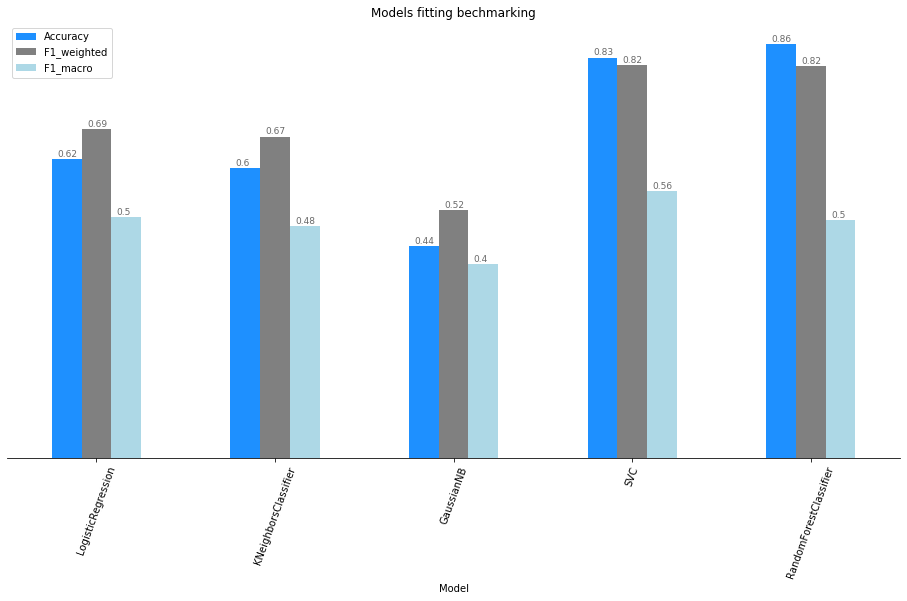

In [88]:
#Benchmarking of models:

models_bench = pd.DataFrame(list_scores, columns = ['Model', 'Accuracy', 'F1_weighted', 'F1_macro'])
models_bench.set_index(["Model"], inplace=True)

ax = models_bench.plot(kind='bar', figsize=(16,8),color=['dodgerblue', 'grey','lightblue'], title='Models fitting bechmarking', rot=70)
ax.set_alpha(0.8)
#ax.axis('off')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.axes.get_yaxis().set_visible(False)

#Writing labels
for i in ax.patches:
    ax.text(i.get_x()+0.03, i.get_height()+0.005, str(round((i.get_height()), 2)), fontsize=9, color='dimgrey')

## Tunning hyperparameters (RandomSearchCV)

Two potential models for the data are Random Forest classifier and Support Vector Classification

### a) Random Search for Random Forest

In [89]:
# Limit the number of folds and samples

cv=5
n_iter=5

# Defining estimators and search space
#n_estimators = [int(x) for x in np.linspace(start = 80, stop = 100, num = 5)]
n_estimators = [10, 50 , 100 , 200, 500]
#max_depth = [int(x) for x in np.linspace(start=10, stop=100, num = 5)]
#min_samples_leaf = [int(x) for x in np.linspace(start=200, stop=400, num = 5)]
min_samples_leaf = [5, 10, 50, 100 , 200]

bootstrap = [True] #to generalize better

hyperparameters = dict(n_estimators=n_estimators,
                       #max_depth=max_depth,                           
                       min_samples_leaf=min_samples_leaf,                            
                       bootstrap=bootstrap
                       )

clf_random_cv = RandomizedSearchCV(RandomForestClassifier(random_state=42), 
                          hyperparameters, 
                          cv=cv, 
                          n_iter=n_iter,       
                          scoring='f1_weighted')


In [90]:
clf_random_cv.fit(X_train,y_train)


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [91]:
clf_random_cv.best_params_

{'n_estimators': 200, 'min_samples_leaf': 10, 'bootstrap': True}

In [92]:
y_pred = clf_random_cv.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       390
           1       0.87      1.00      0.93      2698

    accuracy                           0.87      3088
   macro avg       0.44      0.50      0.47      3088
weighted avg       0.76      0.87      0.81      3088



/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [92]:
from sklearn.metrics import r2_score
from rfpimp import permutation_importances

def r2(rf, X_train, y_train):
    return r2_score(y_train, rf.predict(X_train))

perm_imp_rfpimp = permutation_importances(clf_random_cv, X_train, y_train, r2)

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/model_selection/_search.py:266: UserWarning: The total space of parameters 16 is smaller than n_iter=20. Running 16 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)


In [94]:
perm_imp_rfpimp

,Importance
Feature,
bon appétit,0.075049
desc_n_characters,0.047841
gourmet,0.047639
vegetarian,0.042582
directions_n_characters,0.036715
...,...
fruit juice,-0.000910
frozen dessert,-0.000910
cranberry,-0.001517


In [175]:
# Error bars vs. number of trees (OOB vs n_estimators)

list_n_estimators = [20,50,100,200,400, 800]
list_oob_scores = []
for i in list_n_estimators:
    clf= model=RandomForestClassifier(n_estimators=i,oob_score=True,random_state=42)
    clf.fit(X_train, y_train)
    list_oob_scores.append([i,clf.oob_score_])



/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:460: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: divide by zero encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/ensemble/forest.py:465: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])


In [176]:
print(list_oob_scores)

[[20, 0.7085786073223259], [50, 0.7383345297918162], [100, 0.7499641062455132], [200, 0.7563173007896626], [400, 0.758829863603733], [800, 0.7619885139985643]]


### b) Random Search for Support Vector Classifier

In [88]:
# Defining estimators and search space
cv=3
n_iter=1
#C = [10,100,1000,10000]
C = [1]
kernel = ['rbf','poly','linear' ]
#kernel = ['linear','rbf','poly']
#gamma = [0.1,0.01,0.001,1]
#gamma=[0.001]
hyperparameters = dict(C=C,
                       kernel=kernel#,                           
                       #gamma=gamma
                       )

svc_random_cv = RandomizedSearchCV(SVC(random_state=42), 
                          hyperparameters, 
                          cv=cv, 
                          n_iter=n_iter,       
                          scoring='f1_weighted')



In [89]:
X_std = StandardScaler().fit_transform(X_train)
svc_random_cv=SVC(random_state=42, kernel='poly')
svc_random_cv.fit(X_std,y_train)

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=42,
    shrinking=True, tol=0.001, verbose=False)

In [180]:
# Best hyperparameters
svc_random_cv.get_params()

{'C': 1.0,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'auto_deprecated',
 'kernel': 'poly',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [177]:
#y_pred = svc_random_cv.predict(X_train)
y_pred = svc_random_cv.predict(X_std)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.99      0.87      0.93      5572
           2       0.99      0.87      0.92      5572
           3       0.50      0.99      0.67      5572
           4       0.99      0.55      0.71      5572
           5       0.98      0.71      0.83      5572

    accuracy                           0.80     27860
   macro avg       0.89      0.80      0.81     27860
weighted avg       0.89      0.80      0.81     27860



In [178]:
X_std2 = StandardScaler().fit_transform(X_test)
y_pred = svc_random_cv.predict(X_std2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.02      0.02      0.02        44
           2       0.05      0.03      0.04        89
           3       0.39      0.84      0.53      1152
           4       0.50      0.11      0.18      1394
           5       0.28      0.16      0.20       409

    accuracy                           0.38      3088
   macro avg       0.25      0.23      0.20      3088
weighted avg       0.41      0.38      0.31      3088



### c) Random Search for Logistic Regression

In [31]:

model = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')

X_std = StandardScaler().fit_transform(X_train)
model.fit(X_std, y_train)

/Users/ivettesulca/anaconda3/envs/ml/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [32]:
y_pred = model.predict(X_std)
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           1       0.73      0.92      0.81      5572
           2       0.63      0.75      0.68      5572
           3       0.49      0.37      0.43      5572
           4       0.49      0.36      0.41      5572
           5       0.60      0.63      0.62      5572

    accuracy                           0.61     27860
   macro avg       0.59      0.61      0.59     27860
weighted avg       0.59      0.61      0.59     27860



In [33]:
X_std2 = StandardScaler().fit_transform(X_test)
y_pred = model.predict(X_std2)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.02      0.32      0.04        44
           2       0.04      0.30      0.08        89
           3       0.44      0.24      0.31      1152
           4       0.53      0.21      0.31      1394
           5       0.23      0.39      0.29       409

    accuracy                           0.25      3088
   macro avg       0.25      0.29      0.20      3088
weighted avg       0.44      0.25      0.29      3088



### Only SVC

In [ ]:
# clf = SVC(random_state=42).fit(X_train, y_train)

# y_pred = clf.predict(X_train)
# cm = confusion_matrix(y_train, y_pred)
# print(cm)
# print(classification_report(y_train, y_pred))

In [ ]:
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print(classification_report(y_test, y_pred))

Evaluation Metric
----

In [ ]:
# y_pred = clf.predict(X_test)
# cm = confusion_matrix(y_test, y_pred)
# print(cm)
# print(classification_report(y_test, y_pred))

In [ ]:
# print("Unweighted F1 score overall: ", round(f1_score(y_test, y_pred, average='macro'), 3))